In [857]:
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from torch.optim.lr_scheduler import ExponentialLR
sns.set_theme()
torch.set_default_dtype(torch.float32) #without it we have underflow and we can encounter problems

In [858]:
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (torch.tensor(x_train,dtype=torch.float32), torch.tensor(y_train,dtype=torch.float32)), (torch.tensor(x_test,dtype=torch.float32), torch.tensor(y_test,dtype=torch.float32))

In [859]:
class Encoder(nn.Module):
    def __init__(self,sizes) -> None:
        super().__init__()
        self.latent_size=sizes[-1]
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.ReLU())
        #self.network.append(nn.Linear(sizes[-2],2*self.latent_size))
        self.encode_mu=nn.Linear(sizes[-2],sizes[-1])
        self.encode_sigma=nn.Linear(sizes[-2],sizes[-1])
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        x=self.network(x)
        mu=self.encode_mu(x)
        sigma=torch.exp(self.encode_sigma(x))
        return mu,sigma

    #def log_like()


class Decoder(nn.Module):
    def __init__(self,sizes) -> None:
        super().__init__()
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.ReLU())
        self.network.append(nn.Linear(sizes[-2],sizes[-1]))
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        return torch.sigmoid(self.network(x))

class VAE_torch(nn.Module):
    def __init__(self,encoder, decoder,latent_size) -> None:
        super().__init__()
        self.latent_size=latent_size
        self.encoder=encoder
        self.decoder=decoder
    
    def forward(self,x,epsilon=0.0):
        mu,sigma=self.encoder(x)
        eps=torch.normal(0,1,(mu.shape[0],self.latent_size))
        sampled_vector=mu+eps*sigma
        return self.decoder(sampled_vector),mu,sigma

    def sample(self,x,epsilon=0.0):
        mu,sigma=self.encoder(x)
        sampled_vector=torch.zeros(x.shape[0],self.latent_size)
        for j in range(mu.shape[0]):
            sampled_vector[j,:]=torch.distributions.Normal(mu[j],sigma[j]).sample()
        print(sampled_vector)
        return self.decoder(sampled_vector)


def KL(mean,sigma,epsilon=0):
    #print (torch.mean((torch.sum(sigma.pow(2),dim=1)+torch.sum(mean.pow(2),dim=1)-torch.sum(torch.log(sigma**2+epsilon),dim=1)-1)))
    return 0.5*torch.sum((torch.sum(sigma.pow(2),dim=1)+torch.sum(mean.pow(2),dim=1)-torch.sum(torch.log(sigma**2+epsilon),dim=1)-1))

def ELBO(values,pred_values,mean,sigma,beta=1):
    #return torch.mean(torch.mean((values-pred_values)**2,dim=1)+KL(mean,sigma))
    #print(nn.functional.binary_cross_entropy(pred_values, values,reduction="sum"))
    return (nn.functional.binary_cross_entropy(pred_values, values,reduction="sum")+beta*KL(mean,sigma))/values.shape[0]

def visualize(res1,VAE):
    new=VAE.sample(res1.expand(5,784))
    f,axes=plt.subplots(2,3,figsize=(21,14))
    ax=axes.flatten()[0]
    ax.imshow(res1.reshape(28,28),cmap="viridis_r")
    ax.set_title("Original image")
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(4)
    for j in range(5):
        ax=axes.flatten()[j+1]
        ax.imshow(new[j,:].detach().numpy().reshape(28,28),cmap="viridis_r")
    plt.tight_layout()

In [860]:
(xtrain,ytrain),(xtest,ytest)=load_mnist()

In [886]:
num_epoch=50
batch=100
VAE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10)
optim=torch.optim.Adam(VAE.parameters(),lr=0.003)
scheduler = ExponentialLR(optim, gamma=0.95)
beta=1
err_train=[]
err_test=[]
for i in range(num_epoch):
    for j in range(0,60000,batch):
        xbatch=xtrain[j:j+batch]
        optim.zero_grad()
        results,mean,sigma=VAE(xbatch)
        loss=ELBO(xbatch,results,mean,sigma,beta=beta)
        loss.backward()
        optim.step()
    with torch.no_grad():
        test_res,mean,sigma=VAE(xtest)
        loss_test=ELBO(xtest,test_res,mean,sigma,beta=beta)
        print("Epoche: ",i,"loss train: {:.3f}".format(loss.item()),"loss test: {:.3f}".format(loss_test.item()))
        err_train.append(loss.item())
        err_test.append(loss_test.item())
    if (i>200):
        scheduler.step()
        print("new step: {:.5f}".format(scheduler.get_last_lr()[0]))

Epoche:  0 loss train: 183.168 loss test: 169.876
Epoche:  1 loss train: 151.246 loss test: 151.335
Epoche:  2 loss train: 138.703 loss test: 139.948
Epoche:  3 loss train: 135.312 loss test: 135.695
Epoche:  4 loss train: 134.401 loss test: 133.313
Epoche:  5 loss train: 132.316 loss test: 133.308
Epoche:  6 loss train: 132.053 loss test: 131.240
Epoche:  7 loss train: 130.680 loss test: 131.052
Epoche:  8 loss train: 131.487 loss test: 131.315
Epoche:  9 loss train: 130.901 loss test: 131.199
Epoche:  10 loss train: 128.728 loss test: 129.185
Epoche:  11 loss train: 129.414 loss test: 128.539
Epoche:  12 loss train: 130.034 loss test: 129.744
Epoche:  13 loss train: 128.143 loss test: 128.195
Epoche:  14 loss train: 128.203 loss test: 127.868
Epoche:  15 loss train: 128.658 loss test: 127.608
Epoche:  16 loss train: 127.395 loss test: 128.446
Epoche:  17 loss train: 127.023 loss test: 128.657
Epoche:  18 loss train: 127.260 loss test: 128.460
Epoche:  19 loss train: 126.704 loss test

Text(0.5, 0, 'epoche number')

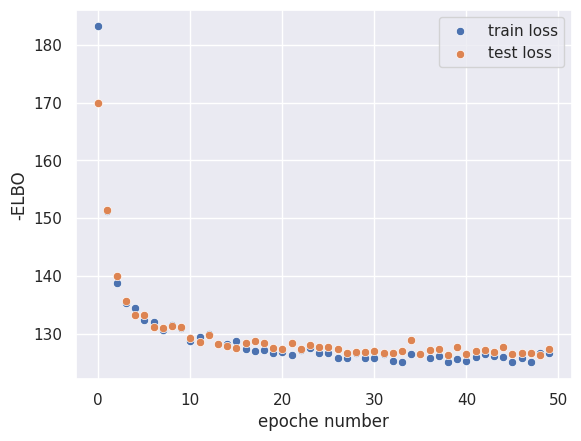

In [887]:
sns.scatterplot(x=np.arange(0,len(err_train)),y=err_train,label="train loss")
sns.scatterplot(x=np.arange(0,len(err_test)),y=err_test,label="test loss")
plt.ylabel(r"-ELBO")
plt.xlabel("epoche number")

tensor([[-0.8023, -2.0378, -0.3450,  0.7722,  1.9290, -1.4779, -1.0580, -0.3207,
         -1.0481, -1.8347],
        [-0.9288, -2.0593,  1.5946,  0.6329,  2.1041, -1.4726, -1.2171, -1.3675,
          0.3117,  0.9241],
        [-1.0440, -2.2802,  1.1015,  0.6652,  1.8853, -1.5110, -1.2840,  0.6293,
         -1.3134,  0.6351],
        [-0.7783, -2.3595,  1.2409,  0.6355,  2.1438, -1.3319, -1.1953,  0.6427,
          1.0515,  1.1828],
        [-0.7952, -2.1618, -1.4677,  0.8322,  2.2954, -1.3605, -1.0188, -2.1456,
          1.0593,  0.1937]])


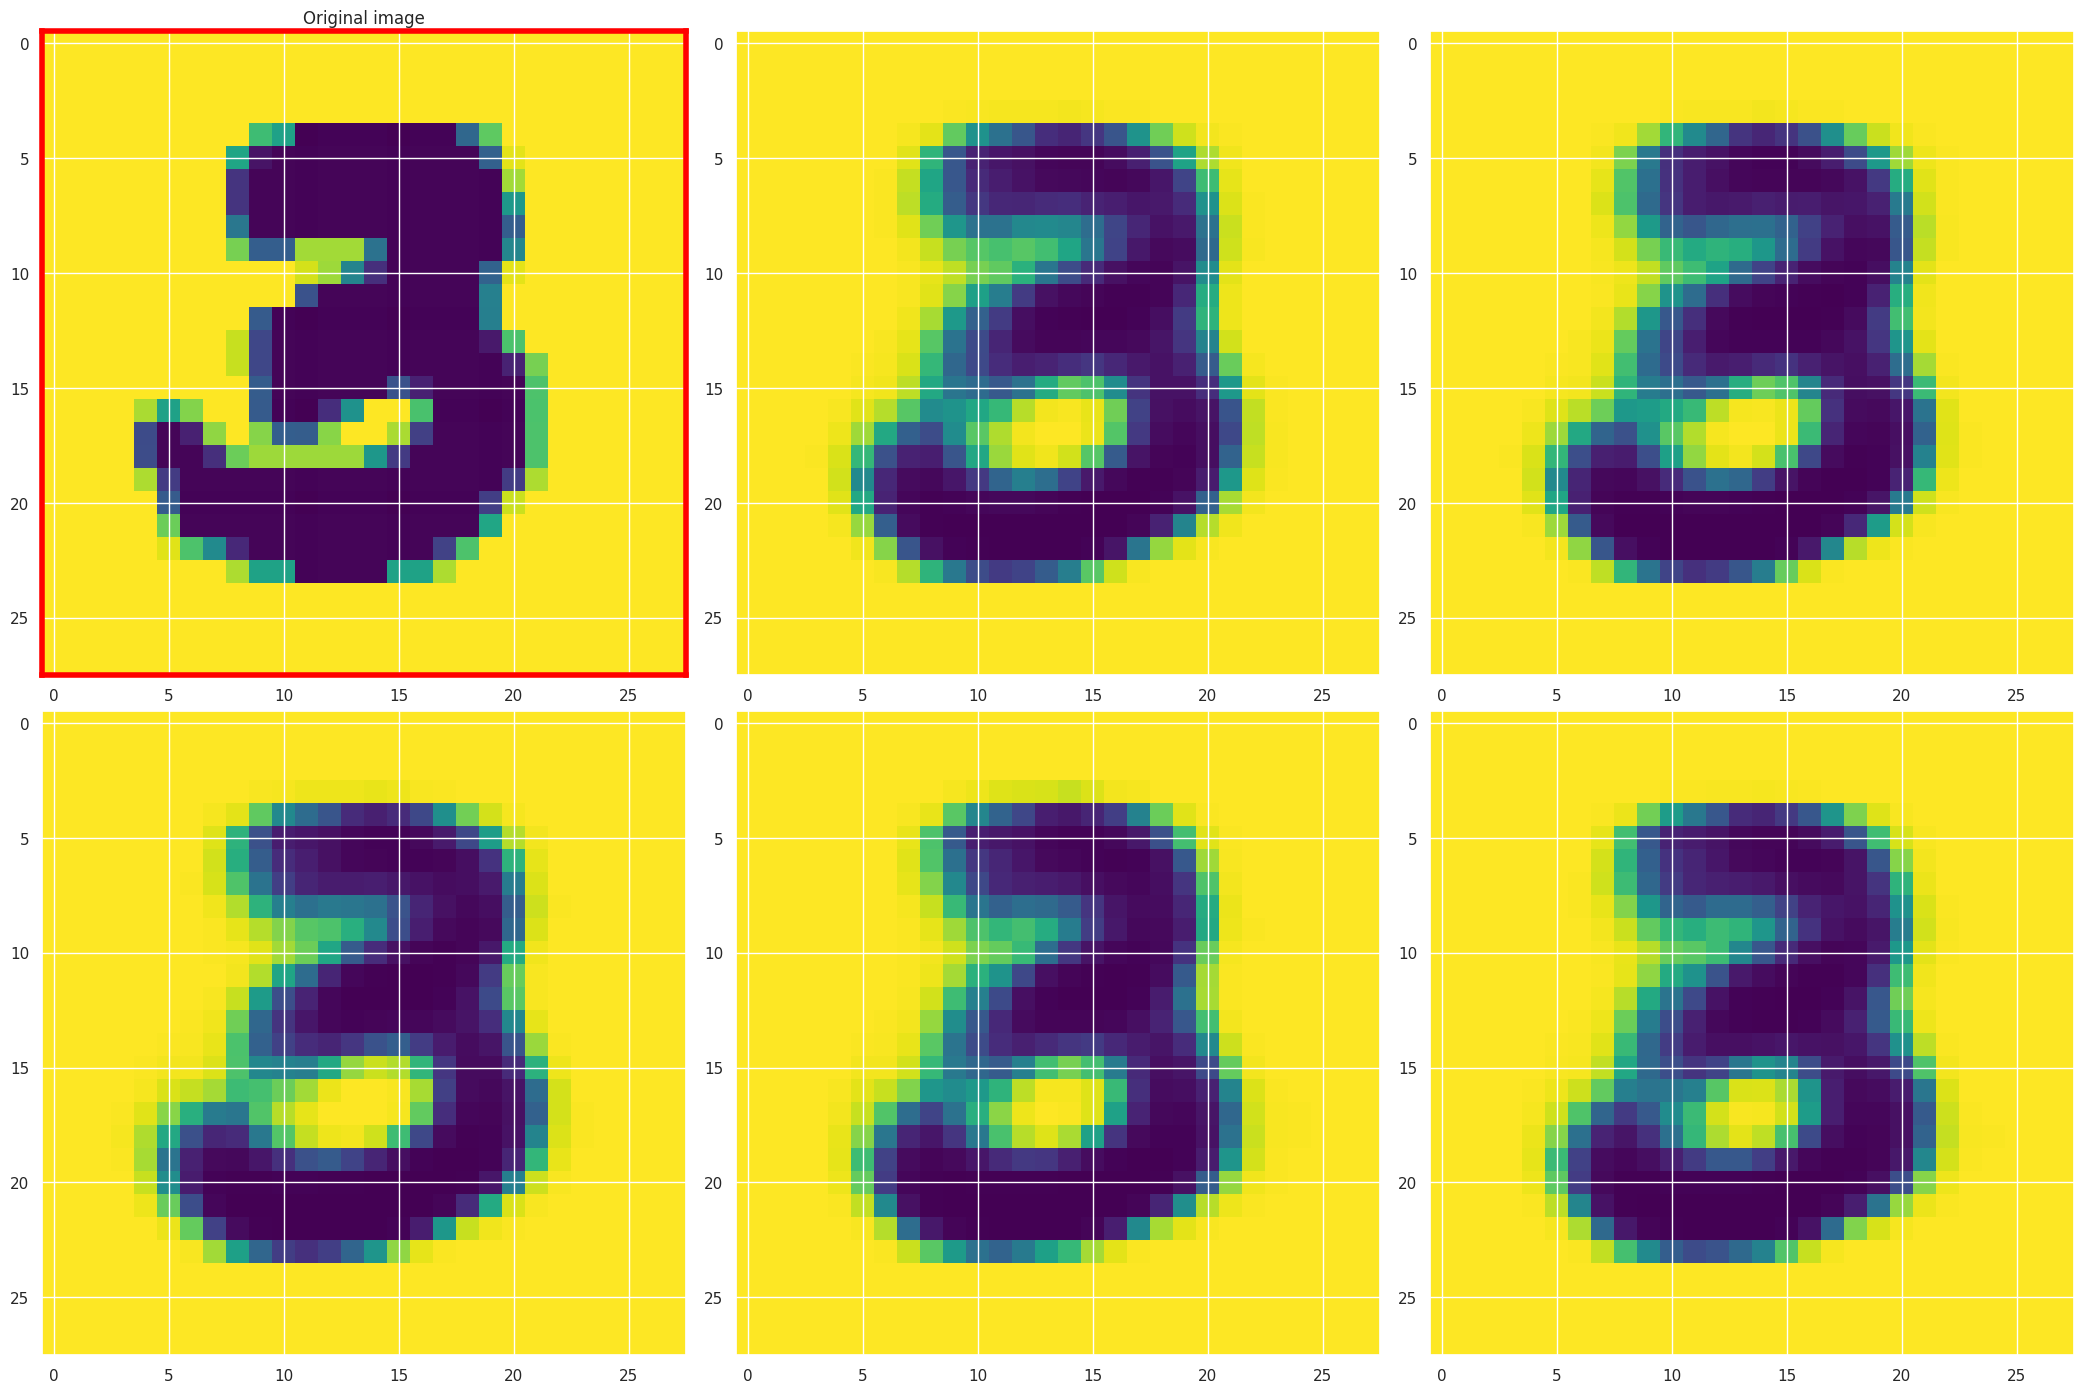

In [897]:
n=200
visualize(xtest[n],VAE)